In [19]:
import numpy as np
from numpy import linalg
from scipy import linalg as splinalg
import matplotlib.pyplot as plt
from scipy import sparse as sp
import scipy.sparse.linalg
from functools import reduce
import itertools
from scipy import linalg
from scipy.linalg import expm
from scipy.special import comb
from itertools import combinations_with_replacement
from collections import Counter
import copy
from scipy.linalg import ishermitian
import seaborn as sns

# Bose-Hubbard Model

In [31]:
def normalizeWF(psi,**kwargs):
    shape, dtype = psi.shape, psi.dtype
    NWF = psi
    if np.array_equal(psi, np.zeros(shape, dtype = dtype)) == True:
        NWF = psi
    elif np.vdot(psi, psi) == 0:
        NWF = psi
    else:
        NWF = psi/(np.sqrt(np.vdot(psi, psi)))
    return NWF

In [32]:
params = {
    'N': 21, # no. of sites
    't':1.0,
    'localized_site': 10,
    'T': 20,
    'tau': 0.01
}

In [33]:
def create_heatmap(X, Y, probabilities):
    X = np.array(X)
    Y = np.array(Y)
    probabilities = np.array(probabilities)
    probability = []
    for i, prob in enumerate(probabilities):
        probability += [float((np.abs(prob))**2)]
    plt.figure(figsize=[7, 5])
    p = plt.get_cmap('Blues')
    
#     sns.scatterplot(x=X, y = Y, hue=probability, palette="viridis")

    x_unique = np.unique(X)
    y_unique = np.unique(Y)
    heatmap_data = np.zeros((len(y_unique), len(x_unique)))

    x_index = {value: idx for idx, value in enumerate(x_unique)}
    y_index = {value: idx for idx, value in enumerate(y_unique)}

    for (x, y, prob) in zip(X, Y, probabilities):
        i = y_index[y]
        j = x_index[x]
        heatmap_data[i, j] = (np.abs(prob))**2

    sns.heatmap(heatmap_data, cmap=p)
    plt.xlabel('Site i')
    plt.ylabel('Site j')
    mu = params['mu']
    plt.title(f'Probability as a function of Sites i and j, Δ={mu}')
    plt.show()

In [34]:
params['dim'] = 0
params['occupationTuple_lst'] = []
params['U'] = 1
params['Map_ParticleLoc_OccupNo']={}
params['map_occupToD_Dim'] = {}
params['N'], params['k'], params['mu'], params['U'] = 20, 2, 0.4, 1
def dimension(params, **kwargs):
    '''
    For k identical bosonic particles on N lattice site, 
    Changes the dim and initializes the vac state
    based on dim.
    '''
    N, k, dim = params['N'], params['k'], int(params['dim']) # N = number of sites, k = no. of identical bosonic particles
    params['dim'] = int(comb(N+k-1, k)) # This is for k identical bosonic particles
    params['vac'] = np.zeros(N)
    pass

dimension(params)
print(params)

{'N': 20, 't': 1.0, 'localized_site': 10, 'T': 20, 'tau': 0.01, 'dim': 210, 'occupationTuple_lst': [], 'U': 1, 'Map_ParticleLoc_OccupNo': {}, 'map_occupToD_Dim': {}, 'k': 2, 'mu': 0.4, 'vac': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])}


In [35]:
def basis_states(params, **kwargs):
    '''
    For k-identical particles on N lattice site, 
    states_vec contain permutations of the particles
    arranged on the lattice.
    '''
    N, vac, k, dim, states_vec, occupation_lst = params['N'], params['vac'], params['k'], params['dim'], [], []
    occupationTuple_lst, Map_ParticleLoc_OccupNo = params['occupationTuple_lst'], params['Map_ParticleLoc_OccupNo']
    # particle_location: Gives all combinations of particle's location.
    # Gives list of tuples in which site each particle is located.
    particle_location = list(combinations_with_replacement(range(N), k)) 
    for i, p_loc in enumerate(particle_location):
        occupationTuple = [0 for _ in range(N)]
        vac = np.zeros(N, dtype=int)
        for site in p_loc:
            occupationTuple[site]+=1
            vac[site]+=1
        states_vec += [vac]
        params['occupationTuple_lst'] += [tuple(occupationTuple)]
        Map_ParticleLoc_OccupNo[p_loc] = tuple(occupationTuple)
    normfactors = {key: [] for key in occupationTuple_lst}
    params['normfactors'] = normfactors
    return states_vec, particle_location, occupationTuple_lst, normfactors, Map_ParticleLoc_OccupNo
bstates = basis_states(params)        
params['states_vec'] = bstates[0]
params['particle_location'] = bstates[1]
params['occupationTuple_lst'] = bstates[2]
params['normfactors'] = bstates[3]
params['Map_ParticleLoc_OccupNo'] = bstates[4]

def Mapping_occupationToD_DimBasis(params, **kwargs):
    occupationTuple_lst, dim, map_occupToD_Dim = params['occupationTuple_lst'], params['dim'], params['map_occupToD_Dim']
    for i, occup_state in enumerate(occupationTuple_lst):
        map_occupToD_Dim[occup_state] = np.eye(1,dim,i)[0]
    zero_tupleComb = tuple(np.zeros(params['N'], dtype=int))
    map_occupToD_Dim[zero_tupleComb] = np.zeros(dim)
    return map_occupToD_Dim

def Normalize_OccupNo(params, **kwargs):
    normfactors = params['normfactors']
    state, factor = kwargs['state'], kwargs['factor']
    if 'annihOp' in kwargs:
        nf = 1/np.sqrt(factor)
    elif 'createOp' in kwargs:
        nf = 1/np.sqrt(factor+1)
    return nf

def numberOp(params, *args, **kwargs): # a_{+, i} a_{-, i} operator
    '''
    It requires the state on which the numberOp act.
    And, the index for which this op is created
    Returns: normalization factors
    '''
    state_vec3_i, state, annihOp, createOp= kwargs['state_vec3_i'], kwargs['state'], kwargs['annihOp'], kwargs['createOp']
    k = kwargs['k']
    vec3, normfactors1 = tuple(state_vec3_i), copy.deepcopy(params['normfactors'])
    if state[k]>0:
        nf1 = Normalize_OccupNo(params, state = tuple(state_vec3_i), 
                                                    factor = state[k], annihOp=annihOp)
        normfactors1[vec3].append(nf1)
        nf2 = Normalize_OccupNo(params, state = tuple(state_vec3_i), 
                          factor = state[k]-1, createOp=createOp)
        normfactors1[vec3].append(nf2)
    elif state[k]==0:
        normfactors1[vec3].append(0)
    return normfactors1[vec3]


def hoppingOp(params, *args, **kwargs):
    '''
    Requires the state on which the HoppingOp acts.
    And, the index for which this op is created
    Returns: Final state and normalization factors
    '''
    states_vec3_i, state, annihOp, createOp= kwargs['state_vec3_i'], kwargs['state'], kwargs['annihOp'], kwargs['createOp']
    k, s = kwargs['k'], kwargs['s']
    vec3, normfactors1 = tuple(states_vec3_i), copy.deepcopy(params['normfactors'])
    if state[k]>0: # C(k+1)_{+}C_(k){-}: states_vec1
        nf1 = Normalize_OccupNo(params, state = tuple(states_vec3_i), 
                                                    factor = state[k], annihOp=annihOp)
        normfactors1[vec3].append(nf1)
        state[k] -= 1 # annihilation
        nf2 = Normalize_OccupNo(params, state = tuple(states_vec3_i), 
                          factor = state[s], createOp=createOp)
        normfactors1[vec3].append(nf2)
        state[s] += 1 # creation
    elif state[k] == 0: #annihilation
        state = np.zeros_like(state)
        normfactors1[vec3].append(0)
    return normfactors1[vec3], state

In [36]:

def HamiltonianElements(params, **kwargs):
    '''
    Returns: Hamiltonian Matrix for Bose-Hubbard Model in the basis of basis vectors,
            and diagonal matrix of this hamiltonian
    '''
    N, states_vec, dim = params['N'], params['states_vec'], params['dim']
    map_occupToD_Dim = Mapping_occupationToD_DimBasis(params)
    normfactors1 = copy.deepcopy(params['normfactors'])
    Hr = np.zeros((dim, dim))
    states_vec1, states_vec2, states_vec3 = copy.deepcopy(states_vec), copy.deepcopy(states_vec), copy.deepcopy(states_vec)
    createOp, annihOp = False, False
    for i, state in enumerate(states_vec1): # Goes through each state
        vec3 = tuple(states_vec3[i])
        for k in range(N-1):
            states_vec1, states_vec2 = copy.deepcopy(states_vec), copy.deepcopy(states_vec)
            states_vec4 = copy.deepcopy(states_vec)
            state = states_vec1[i]
            ### For hopping term
            
            # C(k+1)_{+}C_(k){-}: states_vec1
            normfactors1[vec3], state = hoppingOp(params, state_vec3_i = states_vec3[i], state = state, k = k, s = k+1,
                     annihOp = annihOp, createOp = createOp)
            state1 = map_occupToD_Dim[tuple(state)]
            Hr[i] += -params['t']*(np.prod(normfactors1[vec3])*state1)
            normfactors1[vec3] = []
            # C(k)_{+}C_(k+1){-}: states_vec2
            normfactors1[vec3], states_vec2[i] = hoppingOp(params, state_vec3_i = states_vec3[i], 
                                                           state = states_vec2[i], k = k+1, s = k, annihOp = annihOp, createOp = createOp) 
            state1 = map_occupToD_Dim[tuple(states_vec2[i])]
            Hr[i] += -params['t']*(np.prod(normfactors1[vec3])*state1)
            normfactors1[vec3] = []
            ### For mu and U a_dagger a terms- 
            state = states_vec4[i]
            normfactors1[vec3] = numberOp(params, state_vec3_i = states_vec3[i], state = state, k = k, annihOp = annihOp, createOp = createOp)
            state1 = map_occupToD_Dim[tuple(state)]
            Hr[i] += -params['mu']*(k)*(np.prod(normfactors1[vec3])*state1)
            Hr[i] += -params['U']*(1/2)*(np.prod(normfactors1[vec3])*state1)
            normfactors1[vec3] = []
            if k == (N-2):
                normfactors1[vec3] = numberOp(params, state_vec3_i = states_vec3[i], state = state, k = k+1, annihOp = annihOp, createOp = createOp)
                state1 = map_occupToD_Dim[tuple(state)]
                Hr[i] += -params['mu']*(k+1)*(np.prod(normfactors1[vec3])*state1)
                Hr[i] += -params['U']*(1/2)*(np.prod(normfactors1[vec3])*state1)
            normfactors1[vec3] = []
            
            ### For U term
            states_vec4 = copy.deepcopy(states_vec)
            state = states_vec4[i]
            if state[k]>0:
                normfactors1[vec3] = numberOp(params, state_vec3_i = states_vec3[i], state = state, k = k, 
                     annihOp = annihOp, createOp = createOp)
                normfactors1[vec3] += numberOp(params, state_vec3_i = states_vec3[i], state = state, k = k, 
                     annihOp = annihOp, createOp = createOp)
            elif state[k]==0:
                normfactors1[vec3].append(0)
            state1 = map_occupToD_Dim[tuple(state)]
            Hr[i] += params['U']*(1/2)*(np.prod(normfactors1[vec3])*state1)
            normfactors1[vec3] = []
            if k == (N-2):
                normfactors1[vec3] = numberOp(params, state_vec3_i = states_vec3[i], state = state, k = k+1, 
                     annihOp = annihOp, createOp = createOp)
                normfactors1[vec3] += numberOp(params, state_vec3_i = states_vec3[i], state = state, k = k+1, 
                                         annihOp = annihOp, createOp = createOp)
                state1 = map_occupToD_Dim[tuple(state)]
                Hr[i] += params['U']*(1/2)*(np.prod(normfactors1[vec3])*state1)
            normfactors1[vec3] = []
      
    eigval, eigvec = np.linalg.eig(Hr)
    diagonal_Hr = np.diag(eigval)
    return Hr, diagonal_Hr

In [37]:
Hr, _  = HamiltonianElements(params)
print(Hr)

[[ -0.125       -0.70710678   0.         ...   0.           0.
    0.        ]
 [ -0.70710678  -0.4         -1.         ...   0.           0.
    0.        ]
 [  0.          -1.          -0.8        ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  -3.725       -0.70710678
    0.        ]
 [  0.           0.           0.         ...  -0.70710678 -14.8
   -0.70710678]
 [  0.           0.           0.         ...   0.          -0.70710678
   -3.925     ]]


In [27]:
print(Mapping_occupationToD_DimBasis(params))

{(2, 0): array([1., 0., 0.]), (1, 1): array([0., 1., 0.]), (0, 2): array([0., 0., 1.]), (0, 0): array([0., 0., 0.])}


In [38]:
mp = params['map_occupToD_Dim']
Map_ParticleLoc_OccupNo = params['Map_ParticleLoc_OccupNo'] 

In [39]:
psi0 = np.zeros(params['dim'])
for key, val in Map_ParticleLoc_OccupNo.items():
    if key[0] == key[1]:
        psi0 =(1/np.sqrt(2))*mp[val] 
        # This initializes the state at (19, 19) where the two particles are located.
        # psi0 +=(1/np.sqrt(2))*mp[val] takes a superposition of all such states
        # where the particles are located at the same site.


<Figure size 504x360 with 0 Axes>

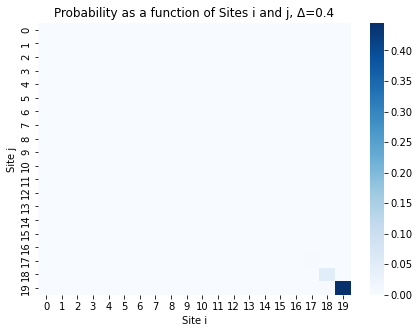

<Figure size 504x360 with 0 Axes>

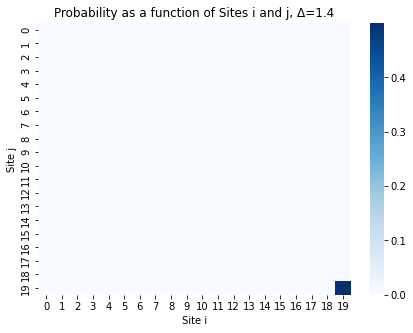

<Figure size 504x360 with 0 Axes>

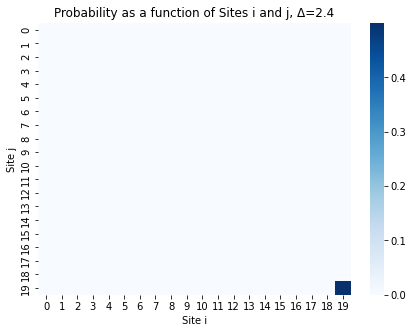

<Figure size 504x360 with 0 Axes>

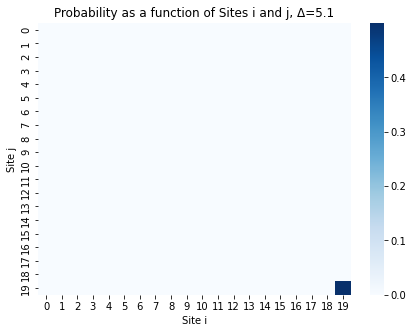

In [40]:
Map_ParticleLoc_OccupNo = params['Map_ParticleLoc_OccupNo'] 

for mu in [0.4, 1.4, 2.4, 5.1]:
    params['mu'] = mu
    Hr, diagonal_Hr = HamiltonianElements(params)

    params['tau'] = 1
    params['T'] = 10
    t_list, psi_t = np.arange(0, params['T'], params['tau']), []
    for i, t in enumerate(t_list):
        U = expm(-1j*Hr*t)
        psi_t +=  [U@psi0]

    Map_ParticleLoc_OccupNo = params['Map_ParticleLoc_OccupNo'] 
    prob, x, y = [], [], []
    map_occupToD_Dim = Mapping_occupationToD_DimBasis(params)
    for psi in psi_t:
        for i, p in enumerate(psi):
            prob+=[p]
            f = np.zeros(params['dim'])
            f[i] = 1.0
            for key, val in map_occupToD_Dim.items():
                if np.array_equal(f, val) == True:
                    for site, v in Map_ParticleLoc_OccupNo.items():
                        if v == key:
                            x += [site[0]]
                            y += [site[1]]
    mu = params['mu']
    plt.figure(figsize=[7, 5])
    p = plt.get_cmap('Blues')
    create_heatmap(x, y, prob)


In [ ]:
psi0 = np.zeros(params['dim'], dtype=complex)
# print(repr(psi0))

In [ ]:
ff, total_comb= 0, 0
for key, val in Map_ParticleLoc_OccupNo.items():
    if key[0] == key[1]:
        psi0 +=(1/np.sqrt(2))*np.array([float(i) for i in val])
        total_comb+=1
        print(f'combination number={ff}')
        print(val,'\n')
    ff+=1
print(total_comb)
print(psi0)

In [ ]:
print(Map_ParticleLoc_OccupNo)

In [ ]:
np.zeros(3)

In [ ]:
np.version.version


In [ ]:
lst = [np.sqrt(2), 3,  1]
# print(reduce(*, lst, 1))
print(np.prod(lst))

In [ ]:
states_vec = params['states_vec']
states_vec1, states_vec2 = copy.deepcopy(states_vec), copy.deepcopy(states_vec)
states_vec1[0][0], states_vec1[0][1] = 1, 1
print(f'states_vec1={states_vec1}')
print(f'states_vec2={states_vec2}')

In [ ]:
print(2+1==2+1)

In [ ]:
import numpy as np
from itertools import combinations_with_replacement

N, k=2, 2
combinations = list(combinations_with_replacement(range(N), k))
print(combinations)